# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
from IPython.display import Audio
from matplotlib import pyplot as plt
from helpers.path_utils import get_base_dir
from scipy.signal import decimate, find_peaks
from helpers.audio_utils import min_max_scale, trim_audio
from helpers.plot import plot_waveform_and_spectrograms, plot_audio_fft

# Load audio

In [2]:
AUDIO_NAME = "SAM-Third Heart Sound.wav"
audio_dir = get_base_dir().joinpath("data", "mobile", "SAM", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

Sample rate:  22050


# Resample to 4KHz

Sample rate:  4000


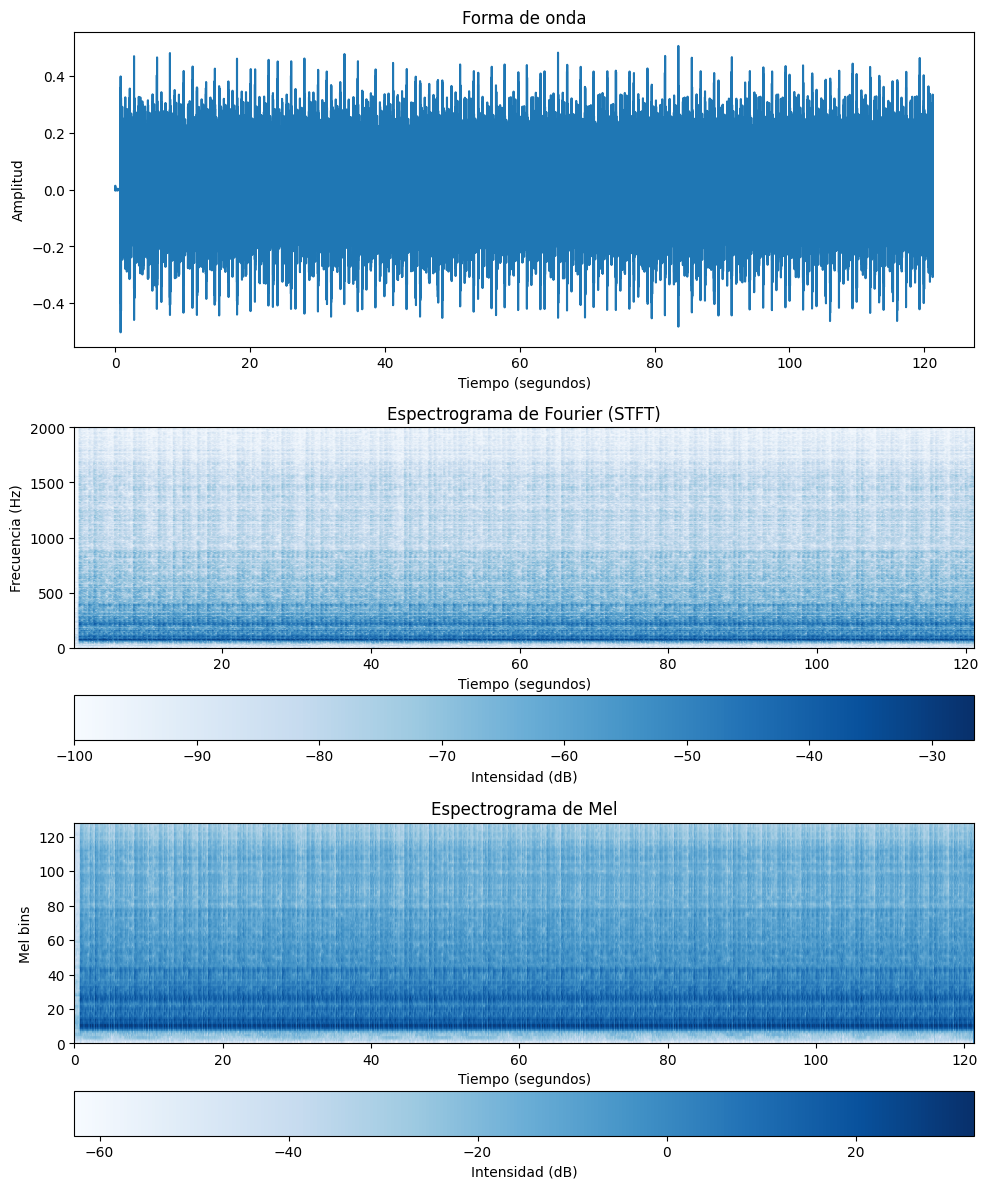

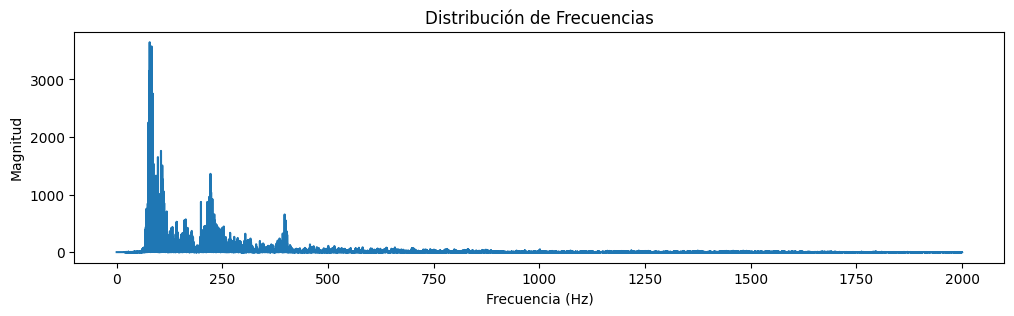

In [3]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(
    orig_freq=sample_rate, new_freq=new_sample_rate
)

audio = resampler(audio)
sample_rate = new_sample_rate

print("Sample rate: ", sample_rate)

plot_waveform_and_spectrograms(audio, sample_rate)
plot_audio_fft(audio, sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Snippet to detect hearbeats

In [4]:
SNIPPET_STARTS = 0
SNIPPET_ENDS = 4

snippet = trim_audio(audio, sample_rate, SNIPPET_STARTS, SNIPPET_ENDS)
audio.shape, snippet.shape

(torch.Size([1, 485200]), torch.Size([1, 16000]))

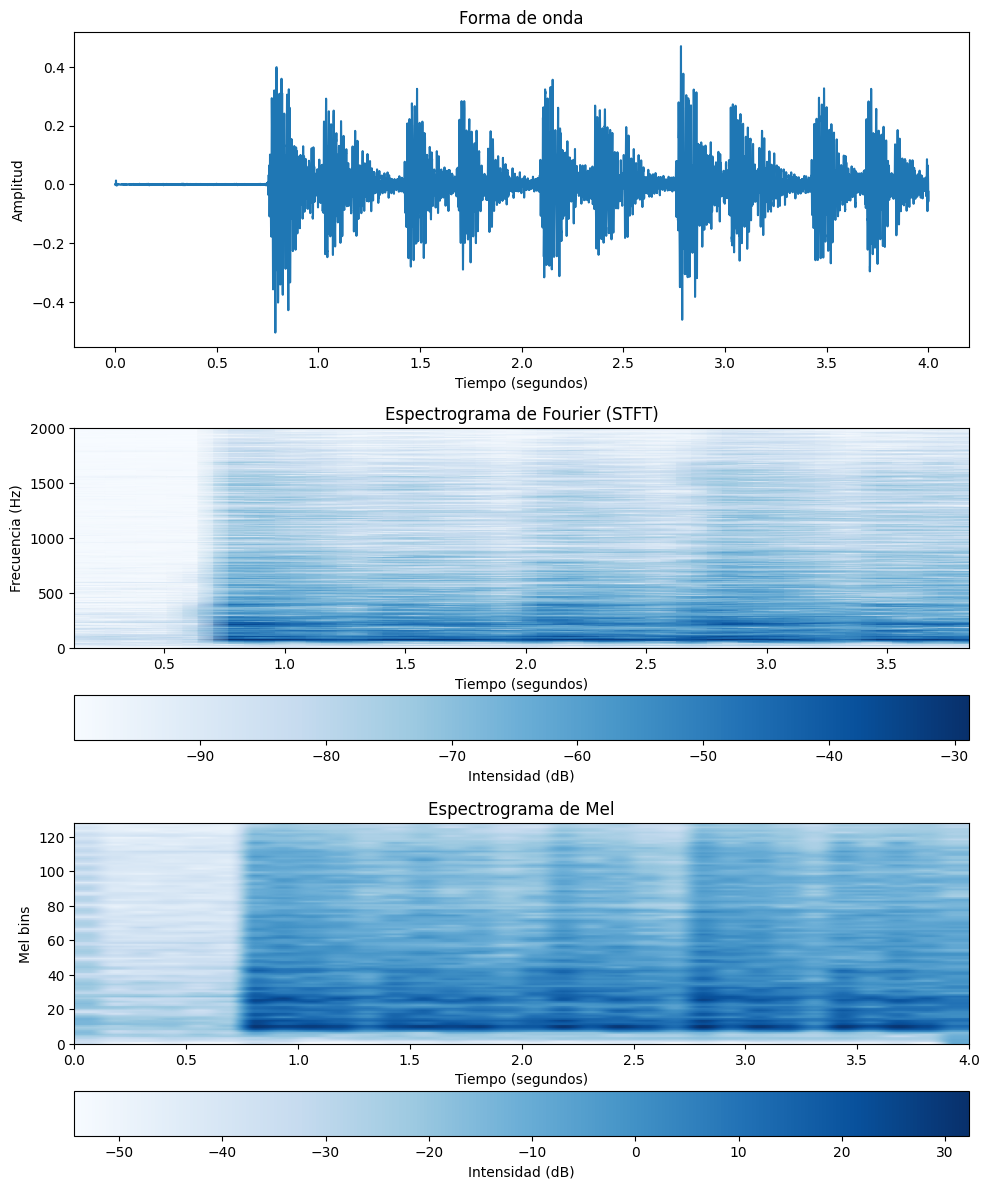

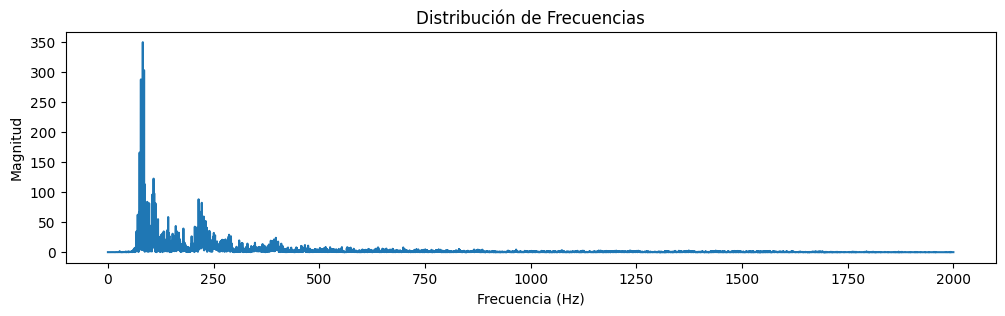

In [5]:
plot_waveform_and_spectrograms(snippet, sample_rate)
plot_audio_fft(snippet, sample_rate)

Audio(snippet, rate=sample_rate, autoplay=True)

# Transform signal to detect heartbeats

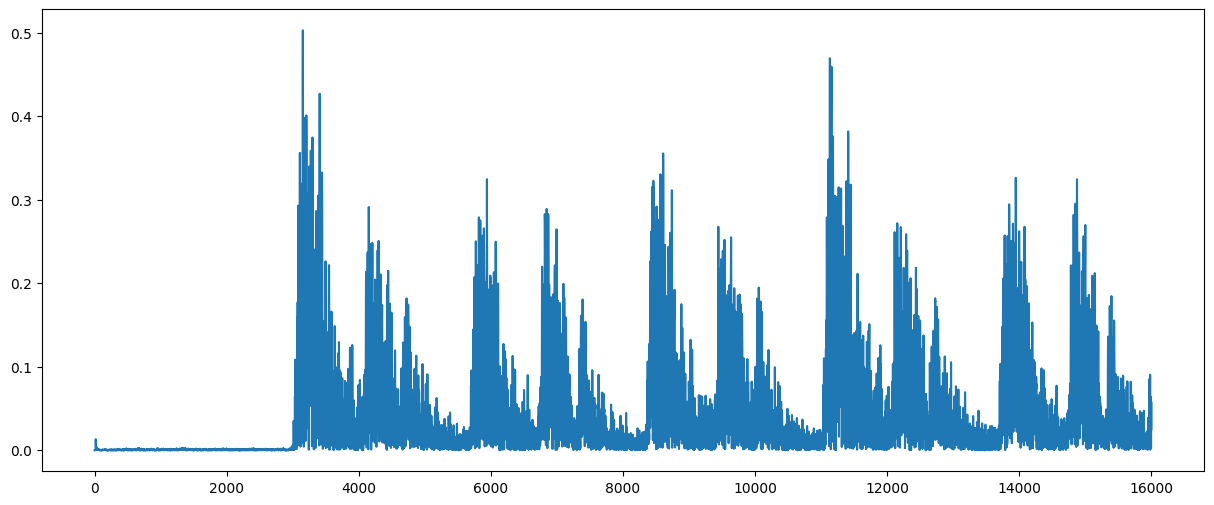

In [6]:
abs_snippet = snippet.abs()
plt.figure(figsize=(15, 6))
plt.plot(abs_snippet.squeeze())

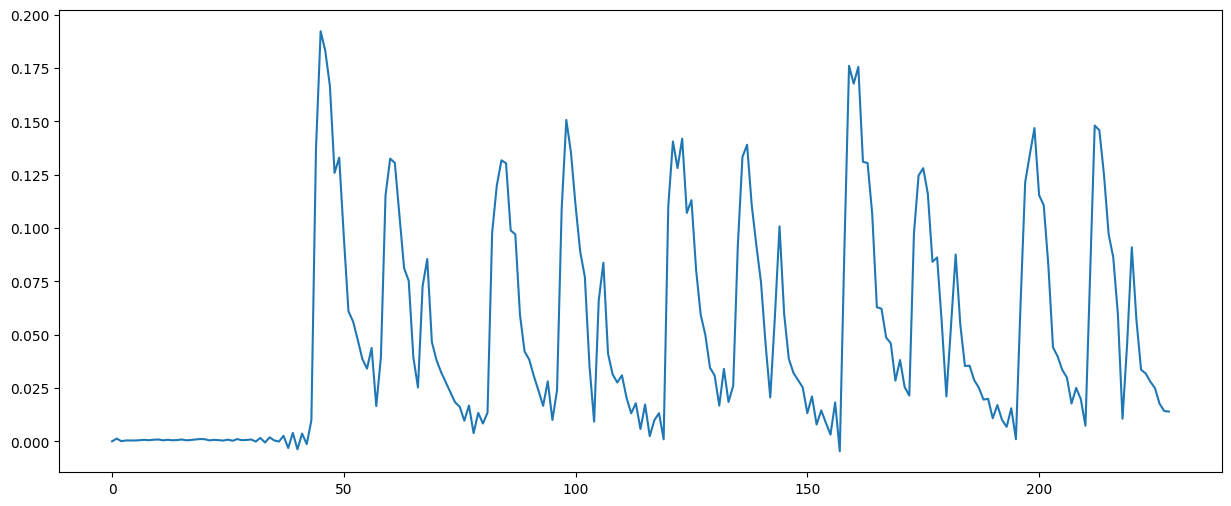

In [7]:
DOWNSAMPLE_FACTOR = 70
downsampled = decimate(abs_snippet, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

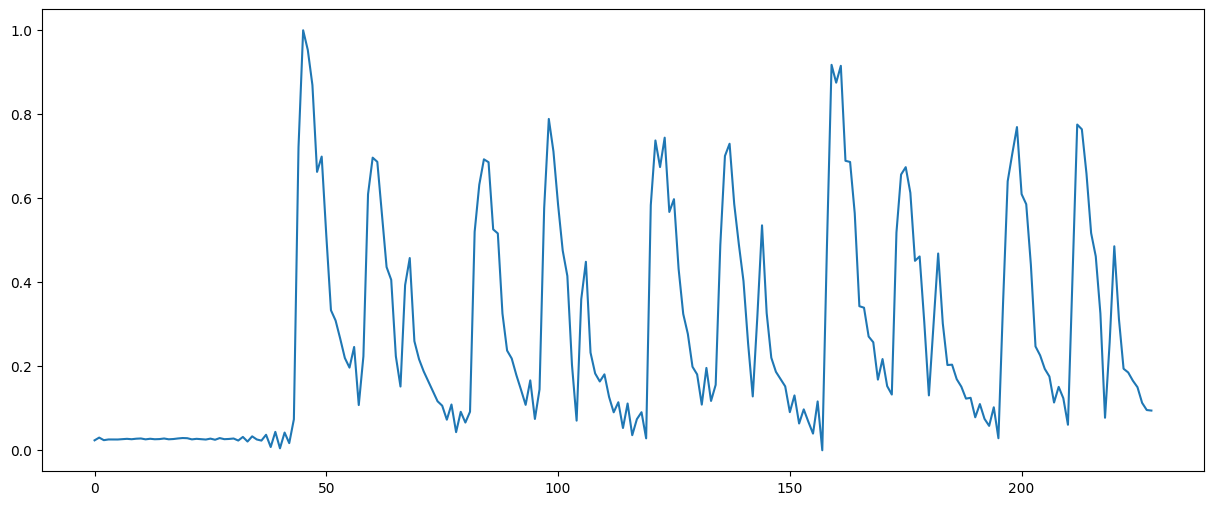

In [8]:
scaled = min_max_scale(Tensor(downsampled.copy())).squeeze()

plt.figure(figsize=(15, 6))
plt.plot(scaled.squeeze())

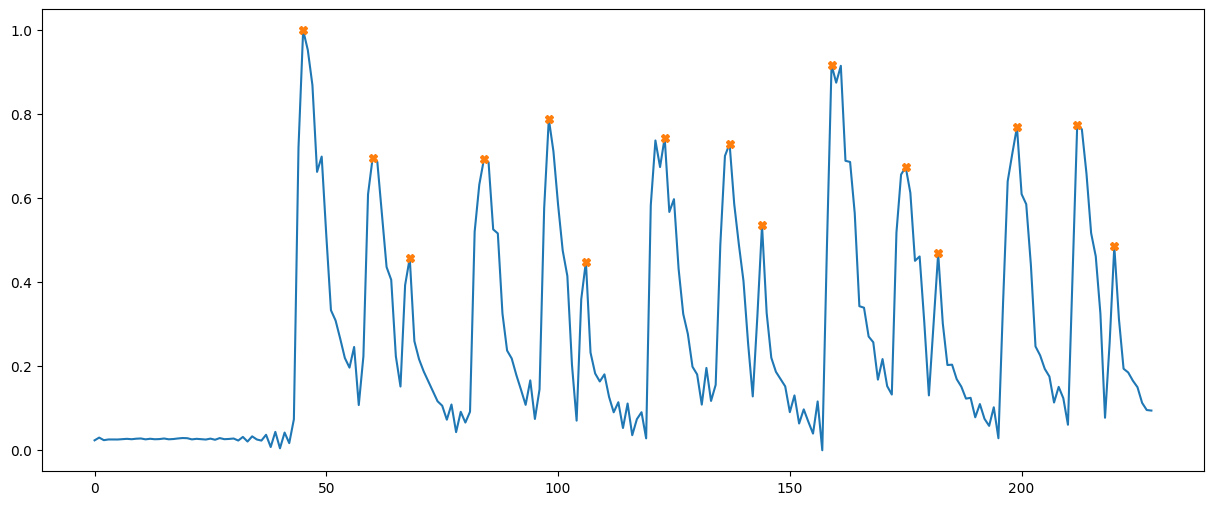

In [9]:
PEAKS_HEIGHT = np.percentile(scaled, 60)
PEAKS_PROMINENCE = 0.15

peaks, _ = find_peaks(scaled, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(scaled)
plt.plot(peaks, scaled[peaks], "X")

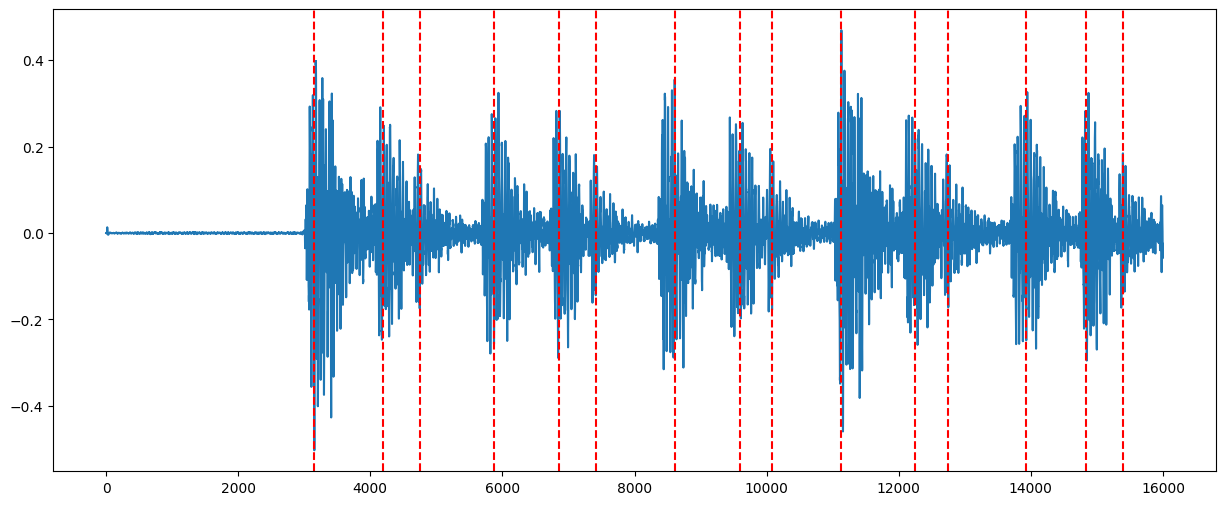

Peaks found in downsampled signal: [ 45  60  68  84  98 106 123 137 144 159 175 182 199 212 220]
Peaks in real signal: [ 3150  4200  4760  5880  6860  7420  8610  9590 10080 11130 12250 12740
 13930 14840 15400]
Difference between each: [1050  560 1120  980  560 1190  980  490 1050 1120  490 1190  910  560]


In [10]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR

plt.figure(figsize=(15, 6))
plt.plot(snippet.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")
print(f"Difference between each: {np.diff(upsampled_peaks)}")